In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xesmf as xe

# Path to data folder
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/'
path_to_raw_trends = path_to_data + 'ts_trends.pickle'

# Load dictionary which containes all 19 year trends
TrendDictionary = pd.read_pickle(path_to_raw_trends)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(30, 72, 144)


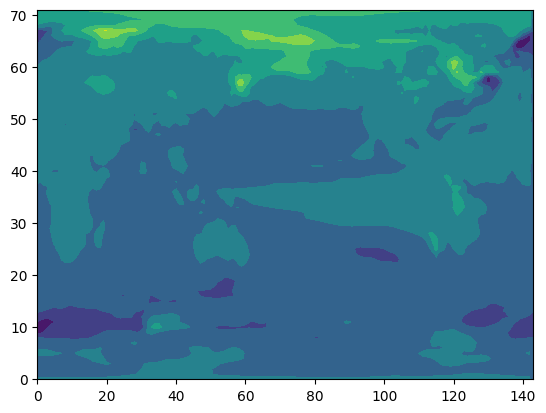

In [4]:
models_for_training_count = 0 # Count of models with at least 10 ensembles
training_maps = []
for model in TrendDictionary.keys():
    if (len(TrendDictionary[model].keys())) >= 11:
        # CMIP6 models must be regridded, below we define input and output grids
        InputGrid = TrendDictionary[model]['grid']
        OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
        regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear")
        models_for_training_count +=1

        # regrid the trend maps for each ensemble member and time period
        EnsembleTrendsArray = []
        for ensemble_name in TrendDictionary[model].keys():
            # data is stored with first element as grid of model
            if ensemble_name == 'grid':
                continue

            ensemble_member = TrendDictionary[model][ensemble_name]

            # return the timeperiods and trend maps in ensemble_member dictionary
            result = ensemble_member.items()
            data = np.array(list(result))
            timeperiods = data[:,0]
            timeperiods = np.array([list(period) for period in timeperiods]) # we will use this as indices for NetCDF
            trend_maps = data[:,1] # these are the indivisual 19 year trend maps

            # Regrid trend map to 2.5 x 2.5 grid
            trend_maps_2p5x2p5 = [regridder(trend_maps[i]) for i in range(0, len(trend_maps))]

            # Return all ensemble trends 
            EnsembleTrendsArray.append(trend_maps_2p5x2p5)
        

        EnsembleTrendsArray = np.array(EnsembleTrendsArray)
        ForcedTrend = np.nanmean(EnsembleTrendsArray, axis=0)
        NaturalTrendsArray = EnsembleTrendsArray - ForcedTrend
        ForcedNaturalTraining = [[NaturalTrendsArray[i], ForcedTrend] for i in range(0, len(NaturalTrendsArray))]

        print(np.shape(ForcedTrend))
        plt.contourf(ForcedTrend[0])

        # Training data will be dumped into NetCDF files
        fileName = path_to_data + model.replace("-", "_") + '_TS_TrendMaps.nc'
        # Create file with dimensions
        ds = nc.Dataset(fileName, 'w', format='NETCDF4')
        ensemble_member = ds.createDimension('ensemble_member', len(ForcedNaturalTraining))
        ForcedNatural = ds.createDimension('ForcedNatural', 2)
        TrendTimePeriod = ds.createDimension('TrendTimePeriod', 30)
        Lat = ds.createDimension('Lat', 72)
        Lon = ds.createDimension('Lon', 144)

        # Add variables to dimensions
        ensemble_member = ds.createVariable('ensemble_member', int, ('ensemble_member',))
        ForcedNatural = ds.createVariable('ForcedNatural', int, ('ForcedNatural',))
        TrendTimePeriod = ds.createVariable('TrendTimePeriod', int, ('TrendTimePeriod',))
        Lat = ds.createVariable('Lat', 'f4', ('Lat',))
        Lon = ds.createVariable('Lon', 'f4', ('Lon',))
        Ts_trends = ds.createVariable('ts_trend', 'f4', ('ensemble_member', 'ForcedNatural', 'TrendTimePeriod', 'Lat', 'Lon'))

        # Assing values to variables
        ensemble_member[:] = np.arange(len(ForcedNaturalTraining)) + 1
        ForcedNatural[:] = [0,1]
        TrendTimePeriod[:] = timeperiods[:,0]
        Lat[:] = np.arange(-88.75, 88.751, 2.5)
        Lon[:] = np.arange(1.25, 358.751, 2.5)
        Ts_trends[:] = ForcedNaturalTraining

        ds.close()

